In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.datasets import load_iris
from scipy.optimize import linear_sum_assignment

## I. Class PCA & k-means

#### Class MyPCA

In [2]:
class MyPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.variance_ratio = None
        self.components = None
        self.evr = None
        self.cevr = None

    def fit(self, X):
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Compute covariance matrix
        cov_matrix = np.dot(X_centered.T, X_centered) / (X.shape[0] - 1)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # Select top n_components
        self.components = sorted_eigenvectors[:, :self.n_components]

        # Compute explained variance ratios
        total_variance = np.sum(sorted_eigenvalues)
        self.variance_ratio = sorted_eigenvalues / total_variance
        self.evr = self.variance_ratio[:self.n_components]
        self.cevr = np.cumsum(self.evr)

        return self

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

#### Z-Score

In [3]:
def z_score(column):
    mean = np.mean(column)
    std = np.std(column)
    return (column - mean) / std

#### Thuật Toán Kmeans

In [4]:
import numpy as np

class MyKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None

    def _euclidean_distances(self, X, centers):
        distances = np.empty((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            distances[:, i] = np.linalg.norm(X - center, axis=1)
        return distances

    def _initialize_centroids(self, X):
        n_samples, n_features = X.shape
        centroids = np.empty((self.n_clusters, n_features), dtype=X.dtype)

        # Chọn ngẫu nhiên centroid đầu tiên
        first_idx = np.random.randint(0, n_samples)
        centroids[0] = X[first_idx]

        # Khoảng cách nhỏ nhất từ mỗi điểm đến centroid gần nhất
        closest_dist_sq = np.full(n_samples, np.inf)

        for c_id in range(1, self.n_clusters):
            dist_to_new_centroid = np.linalg.norm(X - centroids[c_id-1], axis=1)**2
            closest_dist_sq = np.minimum(closest_dist_sq, dist_to_new_centroid)

            probs = closest_dist_sq / closest_dist_sq.sum()
            cumulative_probs = np.cumsum(probs)
            r = np.random.rand()
            next_idx = np.searchsorted(cumulative_probs, r)

            centroids[c_id] = X[next_idx]

        return centroids

    def _assign_labels(self, X):
        distances = self._euclidean_distances(X, self.cluster_centers_)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            points = X[self.labels_ == i]
            if len(points) > 0:
                centroids[i] = points.mean(axis=0)
        return centroids

    def _compute_inertia(self, X):
        inertia = 0.0
        for i in range(self.n_clusters):
            cluster_points = X[self.labels_ == i]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - self.cluster_centers_[i])**2)
        return inertia

    def fit(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        best_inertia = np.inf
        best_centroids = None
        best_labels = None

        for _ in range(self.n_init):
            self.cluster_centers_ = self._initialize_centroids(X)

            for _ in range(self.max_iter):
                self.labels_ = self._assign_labels(X)
                new_centroids = self._compute_centroids(X)

                if np.all(np.linalg.norm(self.cluster_centers_ - new_centroids, axis=1) < self.tol):
                    break

                self.cluster_centers_ = new_centroids

            inertia = self._compute_inertia(X)

            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = self.cluster_centers_.copy()
                best_labels = self.labels_.copy()

        # Sắp xếp centroid theo thứ tự tăng dần trục x để nhãn ổn định
        order = np.argsort(best_centroids[:, 0])
        sorted_centroids = best_centroids[order]

        label_map = np.zeros(self.n_clusters, dtype=int)
        label_map[order] = np.arange(self.n_clusters)
        sorted_labels = np.array([label_map[label] for label in best_labels])

        self.cluster_centers_ = sorted_centroids
        self.labels_ = sorted_labels
        self.inertia_ = best_inertia

        return self

    def predict(self, X):
        distances = self._euclidean_distances(X, self.cluster_centers_)
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_


In [5]:
def k_means_and_plot_data_new(X_data_to_cluster, y_true_encoded, n_clusters = 2): # [:, :2]
    
    kmeans = MyKMeans(n_clusters)
    kmeans.fit(X_pca)
    
    predicted_labels = kmeans.predict(X_pca)
    centroids = kmeans._compute_centroids(X_pca)
    
    print(f"Nhãn cụm dự đoán (ví dụ 10 điểm đầu): {predicted_labels[:10]}")
    print(f"Tọa độ các tâm cụm:\n{centroids}")
    
    # --- Trực quan hóa kết quả ---
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Kết quả phân cụm của K-Means
    plt.subplot(1, 2, 1)
    # Vẽ các điểm dữ liệu, màu theo nhãn cụm dự đoán
    scatter_kmeans = plt.scatter(X_data_to_cluster[:, 0], X_data_to_cluster[:, 1],
                                 c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
    # Vẽ các tâm cụm
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Tâm cụm (Centroids)')
    plt.title(f'K-Means Phân cụm trên X_pca (biểu diễn 2 chiều)')
    plt.xlabel('Thành phần chính 1 (PC1)')
    plt.ylabel('Thành phần chính 2 (PC2)')
    # Tạo legend từ scatter plot
    legend1 = plt.legend(*scatter_kmeans.legend_elements(), title="Cụm K-Means")
    plt.gca().add_artist(legend1) # Thêm legend của scatter
    # Thêm legend cho centroid
    plt.legend(handles=[plt.Line2D([0], [0], marker='X', color='w', label='Tâm cụm (Centroids)',
                              markerfacecolor='red', markersize=10)], loc='upper right') 
    plt.grid(True)
    
    # Plot 2: Dữ liệu với nhãn gốc Y (để so sánh)
    plt.subplot(1, 2, 2)
    scatter_true = plt.scatter(X_data_to_cluster[:, 0], X_data_to_cluster[:, 1],
                               c=y_true_encoded, cmap='viridis', alpha=0.7, edgecolors='k')
    plt.title('Dữ liệu với Nhãn Gốc (Y) của X_pca')
    plt.xlabel('Thành phần chính 1 (PC1)')
    plt.ylabel('Thành phần chính 2 (PC2)')
    plt.legend(*scatter_true.legend_elements(), title="Nhãn gốc Y")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    return predicted_labels

#### Evaluation metrics

In [6]:
def binary_confusion_matrix(y_true, y_hat):
    # Confusion Matrix
    TP = np.sum((y_true == 1) & (y_hat == 1))
    FN = np.sum((y_true == 1) & (y_hat == 0))
    FP = np.sum((y_true == 0) & (y_hat == 1))
    TN = np.sum((y_true == 0) & (y_hat == 0)) 

    cm = np.array([[TN, FP],
               [FN, TP]])
    return cm, TN, FP, FN, TP

def confusion_matrix(y_true, y_hat):
    y_true = np.asarray(y_true)
    y_hat = np.asarray(y_hat)

    labels = np.unique(np.concatenate((y_true, y_hat)))
    n_classes = len(labels)

    label_to_index = {label: idx for idx, label in enumerate(labels)}

    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i in range(len(y_true)):
        true_label = y_true[i]
        predicted_label = y_hat[i]
        
        true_idx = label_to_index[true_label]
        pred_idx = label_to_index[predicted_label]

        cm[true_idx, pred_idx] += 1

    return cm

In [7]:
# Hàm ánh xạ tối ưu bằng thuật toán Hungary
def hungarian_mapping(y_true, y_pred, n_clusters):
    unique_clusters = np.arange(n_clusters)

    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapped_labels = np.zeros_like(y_pred)
    for cluster, label in zip(row_ind, col_ind):
        mapped_labels[y_pred == cluster] = label
    return mapped_labels

In [8]:
def metrics(y_true, y_hat, n_clusters = 2):
    y_hat = hungarian_mapping(y_true, y_hat, n_clusters)

    if (n_clusters != 2):
        acc = np.sum(y_true == y_hat) / y_true.shape[0]
        print(f"\nSo sánh kết quả với nhãn gốc Y:")
        print(f"Accuracy: {acc:.3f}")
        return 
    acc = np.sum(y_true == y_hat) / y_true.shape[0]

    cm, TN, FP, FN, TP = binary_confusion_matrix(y_true, y_hat)
    
    # Recall = TP / (TP + FN)
    denominator_recall = TP + FN
    if denominator_recall == 0:
        rec = 0.0 
    else:
        rec = TP / denominator_recall
        
    # Precision = TP / (TP + FP)
    denominator_precision = TP + FP
    if denominator_precision == 0:
        prec = 0.0 
    else:
        prec = TP / denominator_precision
    
    # F1 = 2 * (Precision * Recall) / (Precision + Recall)
    denominator_f1 = prec + rec
    if denominator_f1 == 0:
        f1s = 0.0 
    else:
        f1s = 2 * (prec * rec) / denominator_f1

    # In kết quả
    print(f"\nSo sánh kết quả với nhãn gốc Y:")
    print(f"Accuracy: {acc:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"F1-score: {f1s:.3f}")

## II. IRIS dataset

In [9]:
# Load dataset
from sklearn.datasets import load_iris

iris = load_iris()
X = iris['data']
y = iris['target']

In [10]:
# Read dataset
df = pd.DataFrame(X, columns=iris['feature_names'])
df['target'] = y
print('Number of columns:', df.shape[0])
print('Name of columns:', iris['feature_names'])
df.head()

Number of columns: 150
Name of columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [11]:
pca = MyPCA(n_components = 2)
X = pd.DataFrame(X)
X_scaled = X.apply(z_score, axis=1)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [12]:
explained_variance_ratio = pca.evr
print("CEVR:", np.sum(explained_variance_ratio))
print("EVR:", explained_variance_ratio[0:5])

CEVR: 0.9905068352544748
EVR: [0.97343527 0.01707156]


Nhãn cụm dự đoán (ví dụ 10 điểm đầu): [0 0 0 0 0 0 0 0 0 0]
Tọa độ các tâm cụm:
[[-1.03372048  0.00988577]
 [ 0.31334344 -0.0453917 ]
 [ 0.7047219   0.03239448]]


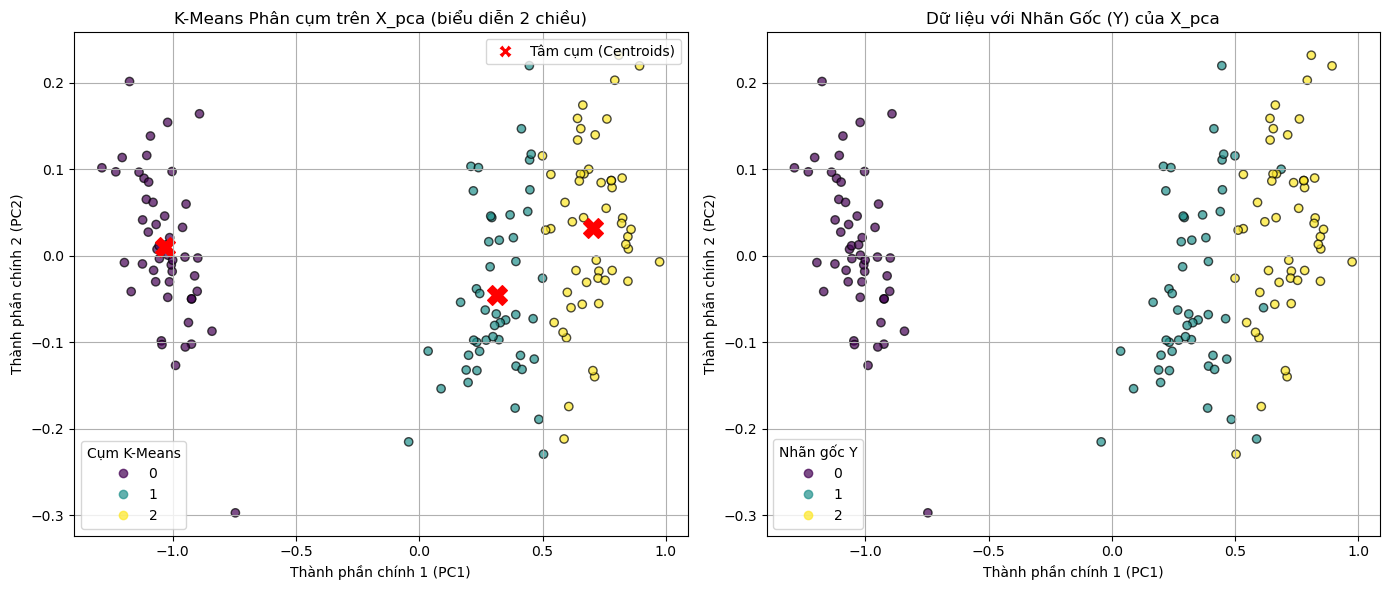

In [13]:
y_hat = k_means_and_plot_data_new(X_pca, y, n_clusters = 3)

In [14]:
print("Độ chính xác sau khi phân cụm phù hợp:", end = "")
metrics(y, y_hat, n_clusters = 3)

Độ chính xác sau khi phân cụm phù hợp:
So sánh kết quả với nhãn gốc Y:
Accuracy: 0.960


## III. Bài toán phân cụm - ABIDE2 dataset

In [15]:
data_path = "./data/ABIDE2(updated).csv"
df = pd.read_csv(data_path, index_col = 0)

In [16]:
df.head()

,site,subject,age,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,ABIDEII-KKI_1,29293,8.893151,Cancer,2750.0,306.0,354.0,2123.0,1451.0,1128.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,ABIDEII-OHSU_1,28997,12.000000,Cancer,2836.0,186.0,354.0,2261.0,1584.0,1241.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,ABIDEII-GU_1,28845,8.390000,Normal,3394.0,223.0,373.0,2827.0,1816.0,1299.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,ABIDEII-NYU_1,29210,8.300000,Cancer,3382.0,266.0,422.0,2686.0,1893.0,1359.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,ABIDEII-EMC_1,29894,7.772758,Normal,3080.0,161.0,346.0,2105.0,1307.0,1004.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


In [17]:
X = df.drop(['group', 'subject', 'site'], axis=1)
y = df['group']
print("X:", X.shape, " y:", y.shape)

X: (1004, 1441)  y: (1004,)


In [18]:
# apply Standard Scaler 
X_scaled = X.apply(z_score, axis=1)

In [19]:
# binary encoding
mapping = {'Normal': 0, 'Cancer': 1}
y_true_encoded = y.map(mapping)
y_true_encoded = y_true_encoded.to_numpy()
y_true_encoded

array([1, 1, 0, ..., 0, 0, 1], shape=(1004,))

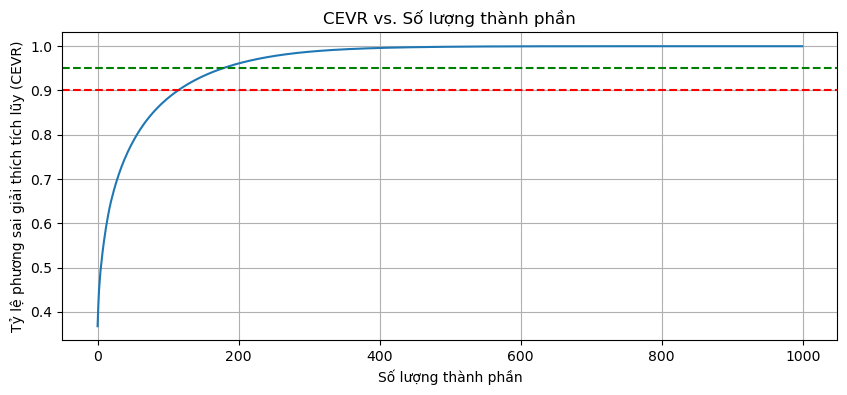

In [20]:
import matplotlib.pyplot as plt

pca_full = MyPCA(n_components=1000)
pca_full.fit(X)

plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca_full.evr))
plt.xlabel('Số lượng thành phần')
plt.ylabel('Tỷ lệ phương sai giải thích tích lũy (CEVR)')
plt.title('CEVR vs. Số lượng thành phần')
plt.grid(True)

plt.axhline(y=0.90, color='r', linestyle='--')
plt.axhline(y=0.95, color='g', linestyle='--')
plt.show()

In [21]:
pca = MyPCA(n_components = 2)
X_to_PCA = X_scaled 
pca.fit(X_to_PCA)
X_pca = pca.transform(X_to_PCA)


print("X_PCA shape:", X_pca.shape)

explained_variance_ratio = pca.evr
print("CEVR:", np.sum(explained_variance_ratio))
print("EVR:", explained_variance_ratio[0:5])

X_PCA shape: (1004, 2)
CEVR: 0.15135524985487853
EVR: [0.08663063 0.06472462]


Nhãn cụm dự đoán (ví dụ 10 điểm đầu): [0 0 0 1 1 0 0 0 0 0]
Tọa độ các tâm cụm:
[[-1.02131428 -0.0960027 ]
 [ 3.21587389  0.30228948]]


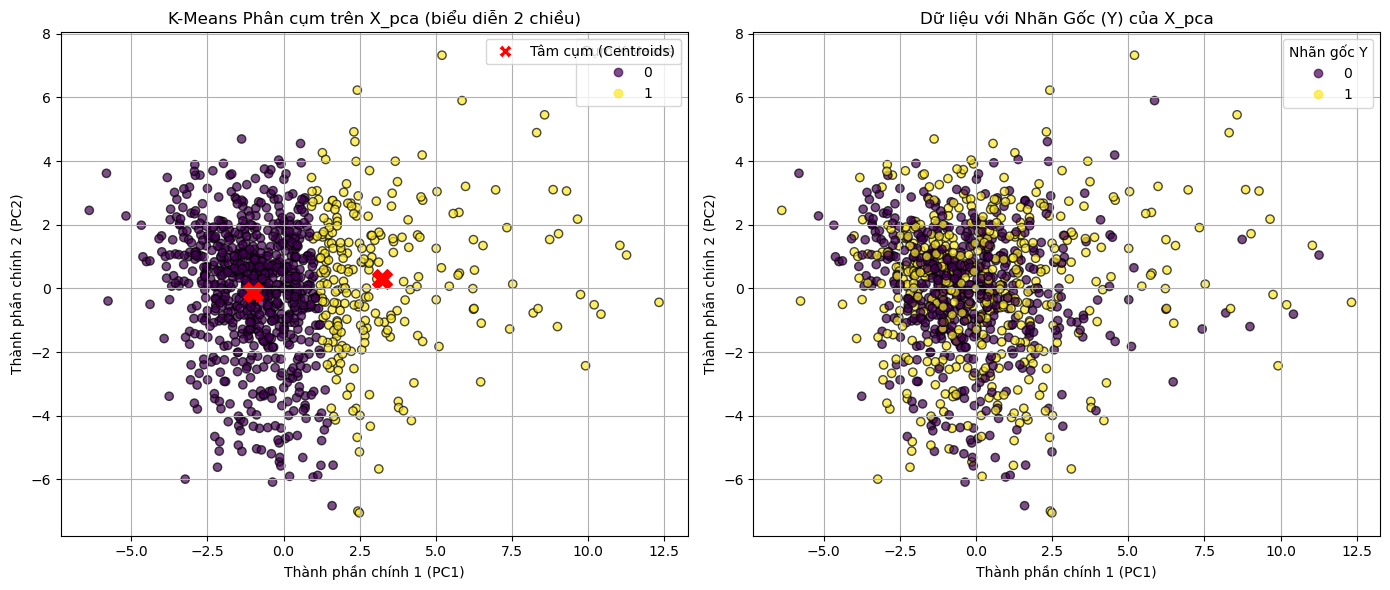


So sánh kết quả với nhãn gốc Y:
Accuracy: 0.581
Recall: 0.307
Precision: 0.587
F1-score: 0.403


In [22]:
predicted_labels_MyKmeans = k_means_and_plot_data_new(X_pca, y_true_encoded)
metrics(y_true_encoded, predicted_labels_MyKmeans, n_clusters = 2)

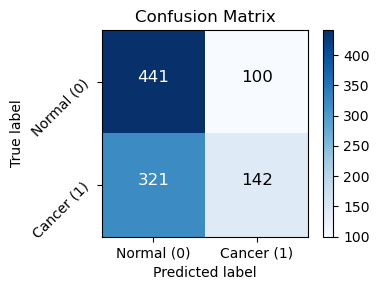

In [23]:
import itertools

# Confusion Matrix
cm, TN, FP, FN, TP = binary_confusion_matrix(y_true_encoded, predicted_labels_MyKmeans)

class_names = ['Normal (0)', 'Cancer (1)']

plt.figure(figsize=(4, 3)) 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) 
plt.title('Confusion Matrix')
plt.colorbar() 

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0) 
plt.yticks(tick_marks, class_names, rotation=45)

thresh = cm.max() / 2. 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=12) 

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() 
plt.show()

**Thuật toán GMM**

In [24]:
class GaussianMixtureModel:
    def __init__(self, n_components, max_iter=100, tol=1e-6, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state if random_state is not None else 0

    def _initialize_gmm(self, X):
        n_samples, n_features = X.shape
        rng = np.random.default_rng(self.random_state)
        weights = np.ones(self.n_components) / self.n_components
        means = X[rng.choice(n_samples, self.n_components, replace=False)]
        covariances = np.array([np.eye(n_features)] * self.n_components)
        return weights, means, covariances

    def _multivariate_gaussian(self, X, mean, cov):
        n = X.shape[1]
        diff = X - mean

        try:
            cov_inv = np.linalg.inv(cov)
            cov_det = np.linalg.det(cov)
        except np.linalg.LinAlgError:
            cov += np.eye(cov.shape[0]) * 1e-6
            cov_inv = np.linalg.inv(cov)
            cov_det = np.linalg.det(cov)

        norm_const = 1.0 / (np.power((2 * np.pi), n / 2) * np.sqrt(cov_det))
        result = norm_const * np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
        return result

    def _e_step(self, X, weights, means, covariances):
        n_samples, n_components = X.shape[0], len(weights)
        responsibilities = np.zeros((n_samples, n_components))

        for k in range(n_components):
            responsibilities[:, k] = weights[k] * self._multivariate_gaussian(X, means[k], covariances[k])

        sum_responsibilities = responsibilities.sum(axis=1)[:, np.newaxis]
        sum_responsibilities[sum_responsibilities == 0] = 1  # tránh chia 0
        responsibilities /= sum_responsibilities

        return responsibilities

    def _m_step(self, X, responsibilities):
        n_samples, n_features = X.shape
        n_components = responsibilities.shape[1]

        weights = responsibilities.sum(axis=0) / n_samples
        means = np.dot(responsibilities.T, X) / responsibilities.sum(axis=0)[:, np.newaxis]

        covariances = np.zeros((n_components, n_features, n_features))
        for k in range(n_components):
            diff = X - means[k]
            weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
            covariances[k] = (weighted_diff.T @ diff) / responsibilities[:, k].sum()
            covariances[k] += np.eye(n_features) * 1e-6  # regularization

        return weights, means, covariances

    def fit(self, X):
        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            raise ValueError("Dữ liệu chứa NaN hoặc Inf.")

        weights, means, covariances = self._initialize_gmm(X)

        for i in range(self.max_iter):
            responsibilities = self._e_step(X, weights, means, covariances)
            new_weights, new_means, new_covariances = self._m_step(X, responsibilities)

            # Kiểm tra hội tụ
            if (np.allclose(new_weights, weights, atol=self.tol) and
                np.allclose(new_means, means, atol=self.tol)):
                self.converged_ = True
                self.n_iter_ = i + 1
                break

            weights, means, covariances = new_weights, new_means, new_covariances

        self.weights = weights
        self.means = means
        self.covariances = covariances

    def predict_proba(self, X):
        return self._e_step(X, self.weights, self.means, self.covariances)

    def predict(self, X):
        responsibilities = self.predict_proba(X)
        return np.argmax(responsibilities, axis=1)
 

In [25]:
def GMM_and_plot_data_new(X_data_to_cluster, y_true_encoded, k=2):
    # Khởi tạo mô hình GMM tự cài
    gmm = GaussianMixtureModel(n_components=k)
    gmm.fit(X_data_to_cluster)
    
    # Dự đoán nhãn
    predicted_labels = gmm.predict(X_data_to_cluster)
    predicted_labels = hungarian_mapping(y_true_encoded, predicted_labels, 2)
    print(f"Nhãn cụm dự đoán (ví dụ 10 điểm đầu): {predicted_labels[:10]}")
    
    # --- Trực quan hóa ---
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Kết quả phân cụm
    plt.subplot(1, 2, 1)
    scatter_pred = plt.scatter(X_data_to_cluster[:, 0], X_data_to_cluster[:, 1],
                               c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
    plt.title('Phân cụm bằng GMM')
    plt.xlabel('Thành phần chính 1 (PC1)')
    plt.ylabel('Thành phần chính 2 (PC2)')
    plt.legend(*scatter_pred.legend_elements(), title="Cụm GMM")
    plt.grid(True)
    
    # Plot 2: Nhãn gốc
    plt.subplot(1, 2, 2)
    scatter_true = plt.scatter(X_data_to_cluster[:, 0], X_data_to_cluster[:, 1],
                               c=y_true_encoded, cmap='viridis', alpha=0.7, edgecolors='k')
    plt.title('Dữ liệu với Nhãn Gốc (Y)')
    plt.xlabel('Thành phần chính 1 (PC1)')
    plt.ylabel('Thành phần chính 2 (PC2)')
    plt.legend(*scatter_true.legend_elements(), title="Nhãn gốc Y")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    return predicted_labels

Nhãn cụm dự đoán (ví dụ 10 điểm đầu): [0 0 0 0 1 0 0 0 0 0]


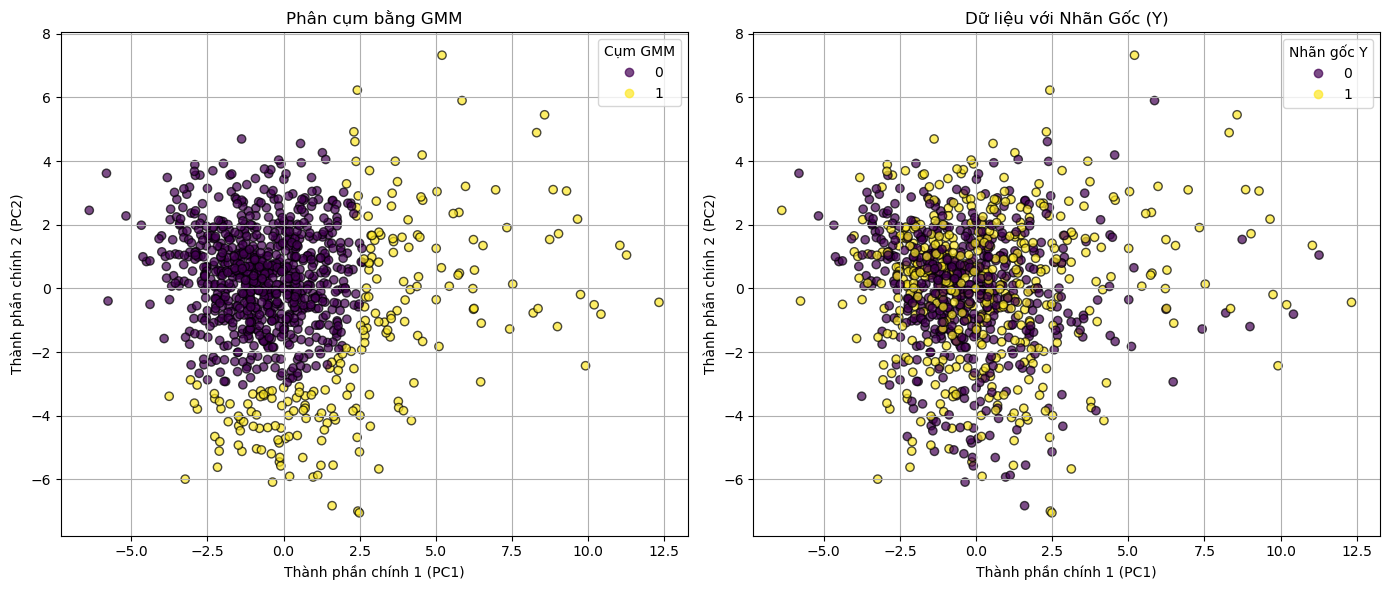


So sánh kết quả với nhãn gốc Y:
Accuracy: 0.567
Recall: 0.266
Precision: 0.564
F1-score: 0.361


In [26]:
predicted_labels_GMM = GMM_and_plot_data_new(X_pca, y_true_encoded)
metrics(y_true_encoded, predicted_labels_GMM, n_clusters = 2)

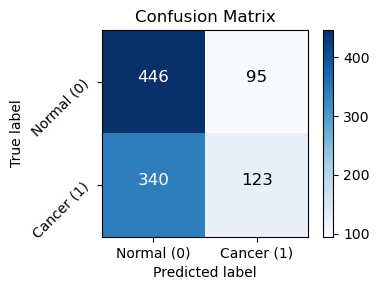

In [27]:
import itertools

# Confusion Matrix
cm, TN, FP, FN, TP = binary_confusion_matrix(y_true_encoded, predicted_labels_GMM)

class_names = ['Normal (0)', 'Cancer (1)']

plt.figure(figsize=(4, 3)) 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) 
plt.title('Confusion Matrix')
plt.colorbar() 

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0) 
plt.yticks(tick_marks, class_names, rotation=45)

thresh = cm.max() / 2. 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=12) 

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() 
plt.show()

## IV. So sánh và đánh giá thuật toán K-means và GMM

In [28]:
list_components = [2, 10, 50, 100, 200]

In [29]:
def evaluate_model(X, y, n_components, model_type='kmeans'):
    pca = MyPCA(n_components=n_components)
    pca.fit(X)
    X_pca = pca.transform(X)

    if model_type.lower() == 'kmeans':
        model = MyKMeans(n_clusters=2)
    else:  # GMM
        model = GaussianMixtureModel(n_components=2)

    model.fit(X_pca)
    y_pred = model.predict(X_pca)

    y_pred = hungarian_mapping(y, y_pred, 2)

    accuracy = np.sum(y == y_pred) / len(y)
    cm, TN, FP, FN, TP = binary_confusion_matrix(y, y_pred)

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return accuracy, precision, recall, f1

In [30]:
results = []
def compare_models(list_comp = list_components):
    for n_components in list_comp:
        kmeans_metrics = evaluate_model(X_scaled, y_true_encoded, n_components, 'kmeans')
        gmm_metrics = evaluate_model(X_scaled, y_true_encoded, n_components, 'gmm')

        results.append({
            'PCA_Components': n_components,
            'Model': 'KMeans',
            'Accuracy': kmeans_metrics[0],
            'Precision': kmeans_metrics[1],
            'Recall': kmeans_metrics[2],
            'F1_Score': kmeans_metrics[3]
        })

        results.append({
            'PCA_Components': n_components,
            'Model': 'GMM',
            'Accuracy': gmm_metrics[0],
            'Precision': gmm_metrics[1],
            'Recall': gmm_metrics[2],
            'F1_Score': gmm_metrics[3]
        })

    df_results = pd.DataFrame(results)
    styled_df = df_results.style.format({
        'Accuracy': '{:.3f}',
        'Precision': '{:.3f}',
        'Recall': '{:.3f}',
        'F1_Score': '{:.3f}'
    })

    return styled_df

comparison_table = compare_models()
display(comparison_table)

,PCA_Components,Model,Accuracy,Precision,Recall,F1_Score
0,2,KMeans,0.576,0.571,0.322,0.412
1,2,GMM,0.567,0.564,0.266,0.361
2,10,KMeans,0.578,0.574,0.328,0.418
3,10,GMM,0.561,0.592,0.153,0.244
4,50,KMeans,0.574,0.568,0.317,0.407
5,50,GMM,0.572,0.630,0.173,0.271
6,100,KMeans,0.577,0.575,0.315,0.407
7,100,GMM,0.533,0.487,0.251,0.331
8,200,KMeans,0.579,0.568,0.361,0.441
9,200,GMM,0.510,0.454,0.309,0.368


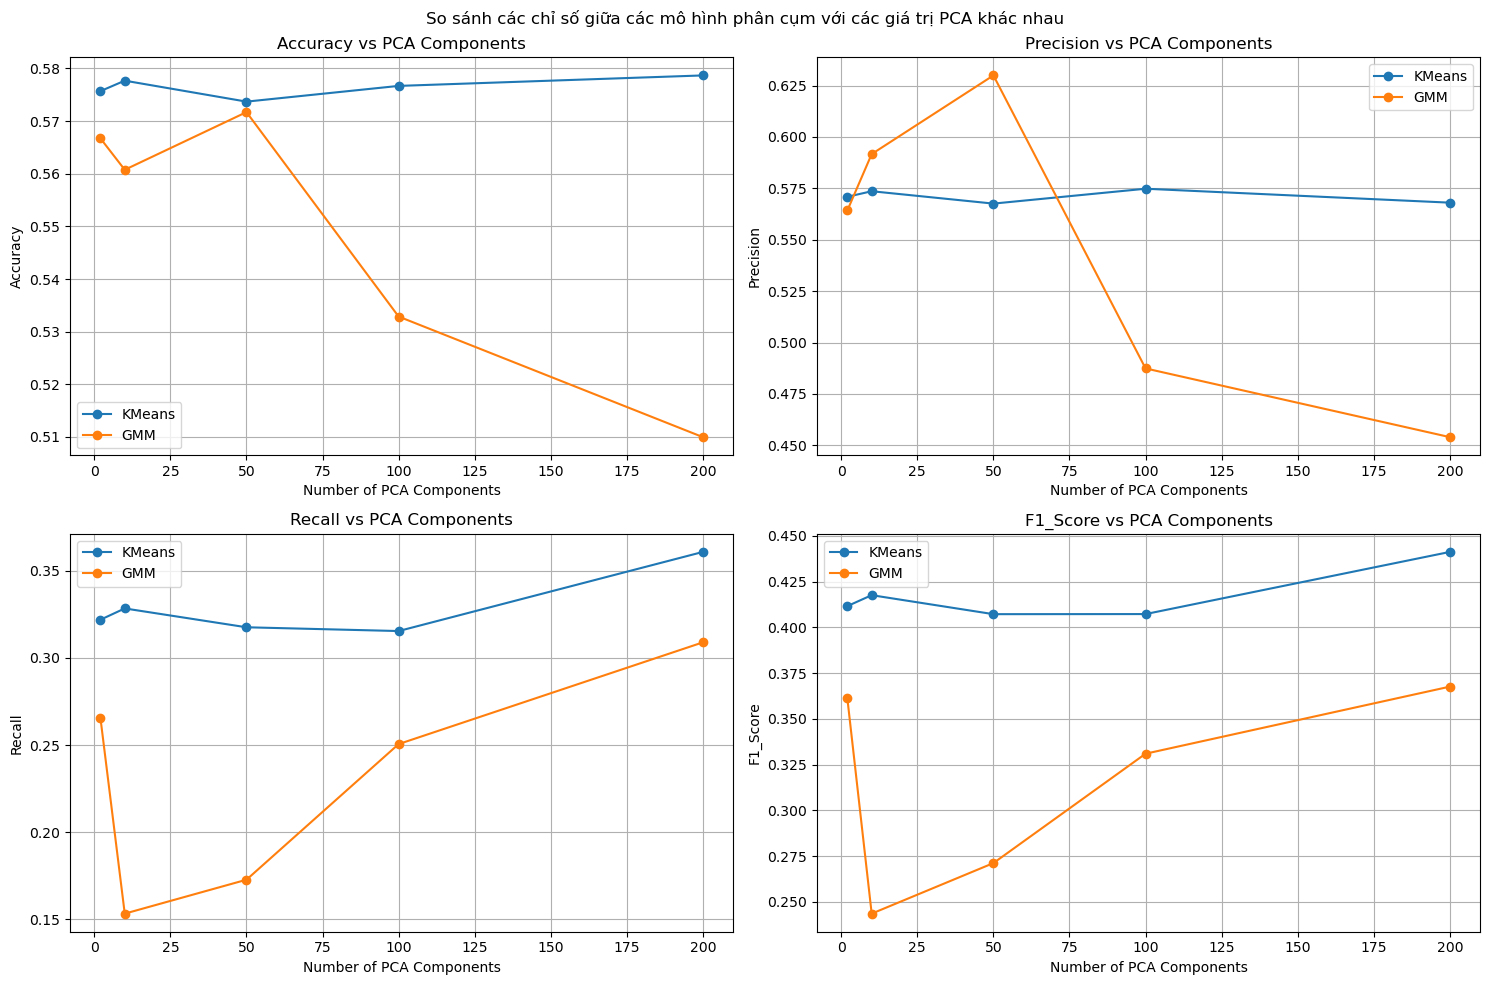

In [31]:
def plot_comparison():
    df_results = pd.DataFrame(results)

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('So sánh các chỉ số giữa các mô hình phân cụm với các giá trị PCA khác nhau')

    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]

        for model in ['KMeans', 'GMM']:
            model_data = df_results[df_results['Model'] == model]
            ax.plot(model_data['PCA_Components'], model_data[metric],
                   marker='o', label=model)

        ax.set_xlabel('Number of PCA Components')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} vs PCA Components')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_comparison()

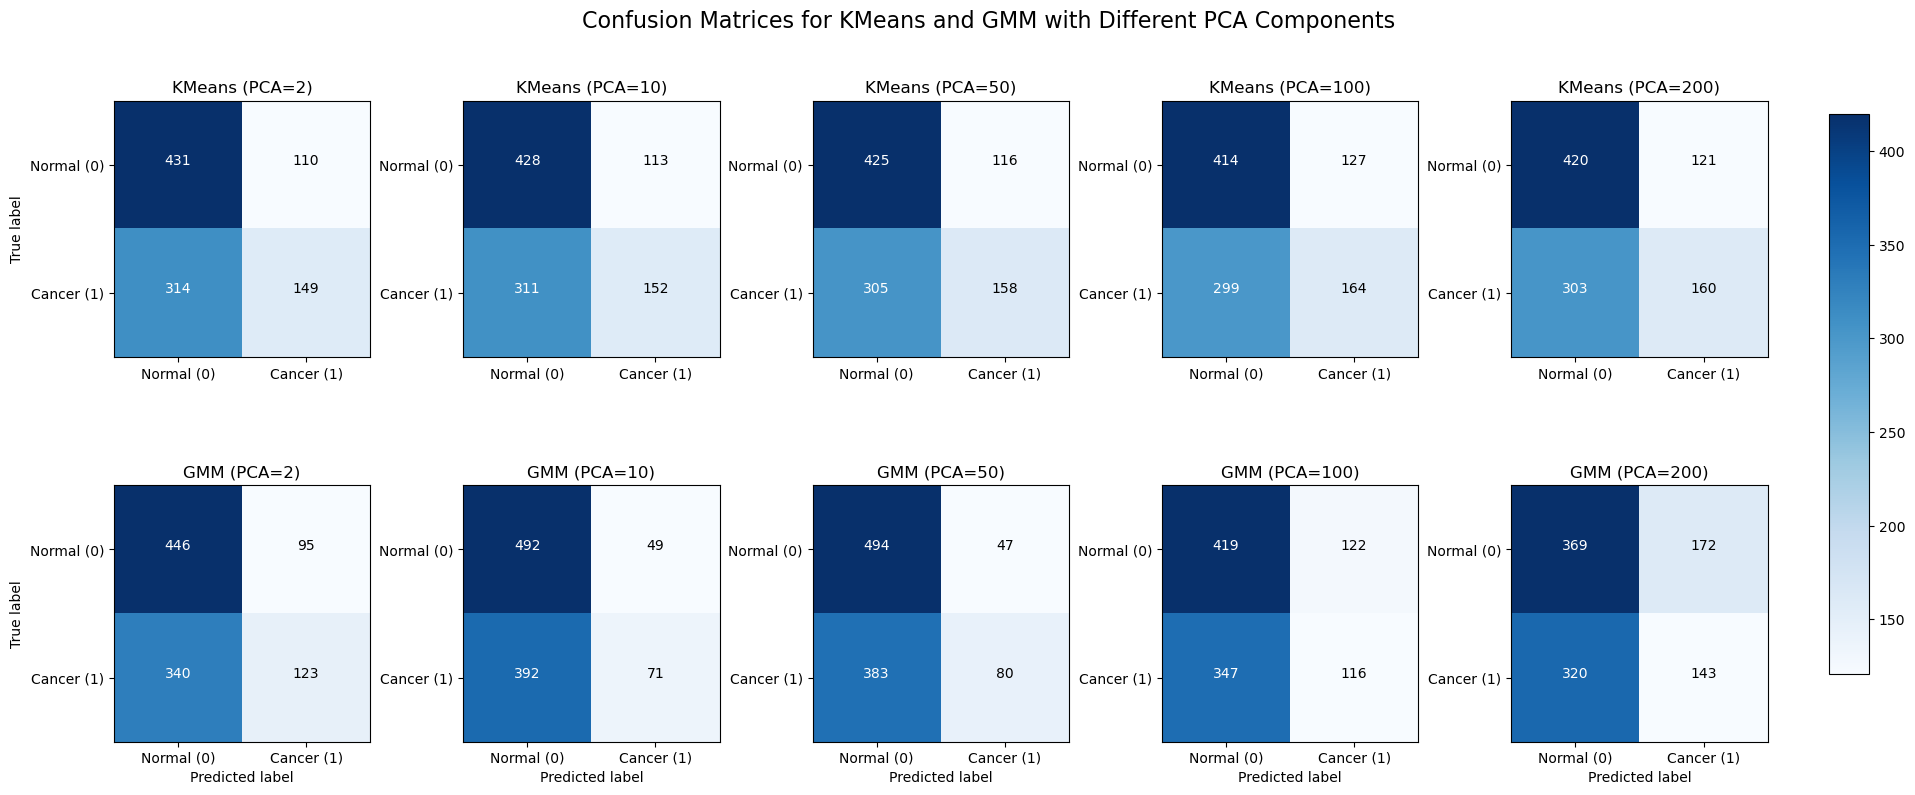

In [32]:
def plot_confusion_matrices(X, y, n_components_list=list_components):
    fig, axes = plt.subplots(2, len(n_components_list), figsize=(20, 8))
    fig.suptitle('Confusion Matrices for KMeans and GMM with Different PCA Components', fontsize=16)

    class_names = ['Normal (0)', 'Cancer (1)']

    for i, n_components in enumerate(n_components_list):
        pca = MyPCA(n_components=n_components)
        pca.fit(X)
        X_pca = pca.transform(X)

        kmeans = MyKMeans(n_clusters=2, random_state=42)
        kmeans.fit(X_pca)
        kmeans_pred = hungarian_mapping(y, kmeans.predict(X_pca), 2)

        gmm = GaussianMixtureModel(n_components=2)
        gmm.fit(X_pca)
        gmm_pred = hungarian_mapping(y, gmm.predict(X_pca), 2)

        cm_kmeans, TN_k, FP_k, FN_k, TP_k = binary_confusion_matrix(y, kmeans_pred)
        cm_gmm, TN_g, FP_g, FN_g, TP_g = binary_confusion_matrix(y, gmm_pred)

        ax_kmeans = axes[0, i]
        im_kmeans = ax_kmeans.imshow(cm_kmeans, interpolation='nearest', cmap=plt.cm.Blues)
        ax_kmeans.set_title(f'KMeans (PCA={n_components})')

        if i == 0:
            ax_kmeans.set_ylabel('True label')

        ax_kmeans.set_xticks(np.arange(len(class_names)))
        ax_kmeans.set_yticks(np.arange(len(class_names)))
        ax_kmeans.set_xticklabels(class_names)
        ax_kmeans.set_yticklabels(class_names)

        # Thêm giá trị vào ô
        thresh_kmeans = cm_kmeans.max() / 2.
        for j, k in itertools.product(range(cm_kmeans.shape[0]), range(cm_kmeans.shape[1])):
            ax_kmeans.text(k, j, format(cm_kmeans[j, k], 'd'),
                         horizontalalignment="center",
                         color="white" if cm_kmeans[j, k] > thresh_kmeans else "black")

        # Biểu diễn GMM confusion matrix
        ax_gmm = axes[1, i]
        im_gmm = ax_gmm.imshow(cm_gmm, interpolation='nearest', cmap=plt.cm.Blues)
        ax_gmm.set_title(f'GMM (PCA={n_components})')

        if i == 0:
            ax_gmm.set_ylabel('True label')

        ax_gmm.set_xlabel('Predicted label')
        ax_gmm.set_xticks(np.arange(len(class_names)))
        ax_gmm.set_yticks(np.arange(len(class_names)))
        ax_gmm.set_xticklabels(class_names)
        ax_gmm.set_yticklabels(class_names)

        # Thêm giá trị vào ô
        thresh_gmm = cm_gmm.max() / 2.
        for j, k in itertools.product(range(cm_gmm.shape[0]), range(cm_gmm.shape[1])):
            ax_gmm.text(k, j, format(cm_gmm[j, k], 'd'),
                      horizontalalignment="center",
                      color="white" if cm_gmm[j, k] > thresh_gmm else "black")

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    # Thêm colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im_kmeans, cax=cbar_ax)
    plt.show()

plot_confusion_matrices(X_scaled, y_true_encoded)